# How we model impermanent loss


Current Pool price P0: 2523.5328326884674


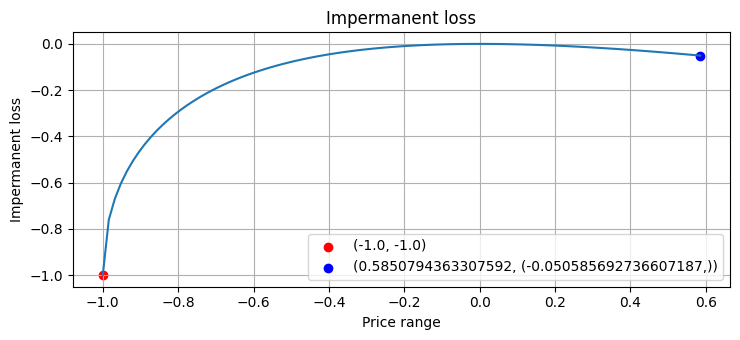

In [1]:
import requests
import numpy as np
from matplotlib import pyplot as plt
import datetime
import time

#extracting pool current price data from v3 subgraph api

def send_query(query, link):

    headers = {'Content-Type': 'application/json'}
    data = {'query': query}

    response = requests.post(link, json=data, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None

url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'

pool_id = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"

unix_date = int(time.mktime(datetime.datetime(2023, 12, 1, 00, 00, 00).timetuple()))
pool_query = f"""
{{
  pool(id: "{pool_id}") {{
    tick
    sqrtPrice
    feeTier
    liquidity
    token0 {{
      symbol
      id
      decimals
      derivedETH
    }}
    token1 {{
      symbol
      id
      decimals
      derivedETH
    }}
  }}
  poolDayDatas(
    where: {{
      pool: "{pool_id}",
      date: {unix_date}
    }}
  ) {{
    date
    volumeUSD
    liquidity
    sqrtPrice

  }}
}}
"""


pool_data = send_query(pool_query, url)

#conversion of SqrtPriceX96 to price ratio of wETH/USDC
sqrt_P = float(pool_data["data"]["pool"]["sqrtPrice"])/2**96
raw_P = sqrt_P**2
t1_dec = int(pool_data["data"]["pool"]["token1"]["decimals"])
t0_dec = int(pool_data["data"]["pool"]["token0"]["decimals"])

#Amount of USDC that represents 1 wETH
adj_P = raw_P/10**(t1_dec - t0_dec)
adj_P0 = 1 / adj_P
print(f'Current Pool price P0: {adj_P0}')

#insert price range (by user)
#sample range to be visualised: from 0 to 4,000
P_a = 0
P_b = 4000

#plotting
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

#Impermanent loss with respect to percentage change in price
def IL_V3(percentage_change):
  d = percentage_change + 1
  return ((2*np.sqrt(d)-1-d)/(1+d-np.sqrt(P_a/adj_P0)-d*np.sqrt(adj_P0/P_b)))

perc_a = (P_a - adj_P0)/ adj_P0
perc_b = (P_b - adj_P0)/ adj_P0

P1_points = np.linspace(perc_a, perc_b, 100)
IL_points = IL_V3(P1_points)

plt.plot(P1_points, IL_points)


plt.title('Impermanent loss')
plt.xlabel('Price range')
plt.ylabel('Impermanent loss')
a_IL = IL_V3(perc_a)
b_IL = IL_V3(perc_b),
plt.scatter(perc_a, a_IL, color='red', label=f'({perc_a}, {a_IL})')
plt.scatter(perc_b, b_IL, color='blue', label=f'({perc_b}, {b_IL})')
plt.legend()
plt.grid(True)
plt.show()




#Finding Tick Liquidity

In [ ]:
#finding liquidityGross over price range, known: tick
#for fee calculation

query = """
{
    ticks(first: 1000, where: { pool: "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640" tickIdx_gte: "197020" tickIdx_lte: "198370" }, orderBy: liquidityGross,orderDirection: desc) {
      tickIdx
      liquidityGross
      liquidityNet
  }
}
"""

tick_liquidity_data = send_query(query, url)

liquidity_over_price_range = 0

for i in tick_liquidity_data["data"]["ticks"]:
  if int(i["liquidityGross"]) > 0:
    liquidity_over_price_range += int(i["liquidityGross"])
  elif int(i["liquidityGross"]) == 0:
    continue

print(liquidity_over_price_range)



31636651738793515128


#Finding our liquidity

In [2]:
#finding our liquidity, given we plan to invest $1000 into the pool.
#(L = liquidity): (L_you / L_others) * (24h_swap_volume * pool_fee_rate)


A = 1000

def t2sqrtp(t):
  return 1.0001**(t/2)

sqrtl = (10**12/t2sqrtp(197020)**2)**0.5
sqrtc = (10**12/t2sqrtp(198000)**2)**0.5
sqrtu = (10**12/t2sqrtp(198370)**2)**0.5

print(sqrtu**2)
print(sqrtl**2)

print(sqrtu)
print(sqrtc)
print(sqrtl)

Px = 2526
Py = 1
delta_L1 = A /((sqrtc - sqrtu) * Py + (1 / sqrtc - 1 / sqrtl) * Px)

print(f"delta L1 is {delta_L1}")


delta_Y = delta_L1 * (sqrtc-sqrtu)
delta_X = delta_L1 * (1/sqrtc-1/sqrtl)


delta_Lx = delta_X * (sqrtl * sqrtu)/(sqrtl - sqrtu)
delta_Ly = delta_Y / (sqrtl - sqrtu)

delta_L = min(delta_Lx, delta_Ly)
print(f"delta L is {delta_L}")

2428.460750964669
2779.4438987734684
49.27941508342676
50.19952301542791
52.720431511639475
delta L1 is 300.64355713466017
delta L is 80.39035191945328


In [ ]:
def get_liquidity0(sqrtA,sqrtB,amount0,decimals):

    if (sqrtA > sqrtB):
          (sqrtA,sqrtB)=(sqrtB,sqrtA)

    liquidity=amount0/((2**96*(sqrtB-sqrtA)/sqrtB/sqrtA)/10**decimals)
    return liquidity

def get_liquidity1(sqrtA,sqrtB,amount1,decimals):

    if (sqrtA > sqrtB):
        (sqrtA,sqrtB)=(sqrtB,sqrtA)

    liquidity=amount1/((sqrtB-sqrtA)/2**96/10**decimals)
    return liquidity



amt1 = 649.5
amt0 = 0.139

sa=(1.0001**(197020/2)*(2**96))
sb=(1.0001**(198370/2)*(2**96))

print(get_liquidity0(sa,sb,amt0,12))
print(get_liquidity1(sa,sb,amt1,12))




4.039504108737941e+16
490384698034.7561


In [ ]:
L = int(pool_data["data"]["pool"]["liquidity"])
tick_cur = int(pool_data["data"]["pool"]["tick"])
print(tick_cur)
tick_bottom = 197670
tick_top = 197680
p_a = 1.0001 ** tick_bottom
p_b = 1.0001 ** tick_top
adj_pa = 1e12 / p_a
adj_pb = 1e12/ p_b
x = L * (p_b ** 0.5 - sqrt_P)/(sqrt_P*p_b ** 0.5)
y = L * (sqrt_P-p_a**0.5)
x_adj = x/1e06
y_adj = y/1e18
print(adj_pa)
print(adj_pb)
print(x_adj)
print(y_adj)
L_1 = x_adj + y_adj * adj_P0
print(f'liquidity: {L_1}')

197729
2604.534907983897
2601.9318049973012
-445391.13990254473
206.42061930857855
liquidity: 89065.03480077029


In [ ]:
#24-hour volume
vol_USD = float(pool_data["data"]["poolDayDatas"][0]['volumeUSD'])
print(vol_USD)

def daily_fee (L_0):
  return L_0 / (L_1 + L_0) * vol_USD * 0.0005

227546421.2054169


# Price Range Prediction

In [ ]:
#expected move of price
import math

sigma = 0.46
S0 = 2519.992110976476
expected_move = S0 * sigma * math.sqrt(1/365)
print(f"Expected move of price is {expected_move}")

Expected move of price is 60.6751111586902


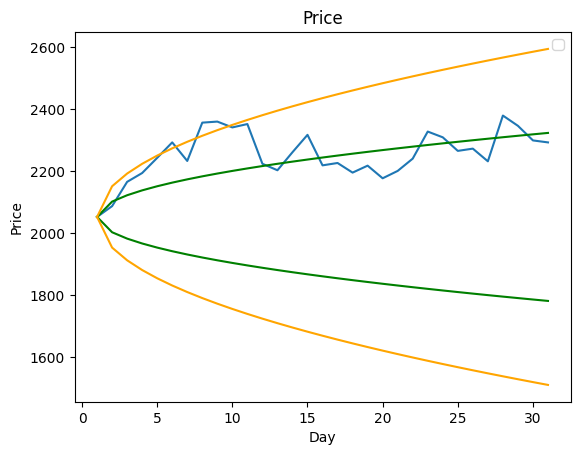

In [ ]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('historical_data_at_0000hrs.csv')

x_values = np.arange(1,32)
plt.plot(x_values, df['Price'])
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Price')
plt.legend()


S0 = df['Price'][0]
sigma = 0.46

def exp_move(T):
  #T in days
  return S0 * sigma * np.sqrt(T/365)

#68% possibility that price lies in 1 time the sigma
def exp_priceup(T):
  return S0 + exp_move(T)

def exp_pricedown(T):
  return S0 - exp_move(T)

#97% possibility that price lies in 2 times the sigma
def exp_priceup_double(T):
  return S0 + 2*exp_move(T)

def exp_pricedown_double(T):
  return S0 - 2*exp_move(T)

y_up = exp_priceup(np.arange(0,31,1))
plt.plot(x_values, y_up, color = 'green')
y_down = exp_pricedown(np.arange(0,31,1))
plt.plot(x_values, y_down, color = 'green')

plt.plot(x_values, exp_priceup_double(np.arange(0,31,1)), color = 'orange')
plt.plot(x_values, exp_pricedown_double(np.arange(0,31,1)), color = 'orange')

plt.show()

# retrieving historical data


In [ ]:
!pip install eth-hash
!pip install pycryptodome
!pip install pysha3
!pip install web3

In [ ]:
!pip install --upgrade web3

In [ ]:
!pip install --upgrade protobuf

In [ ]:
!pip show web3

In [ ]:
import json
from web3 import Web3
import requests

def download_json(url, output_file_path):
    response = requests.get(url)

    if response.status_code == 200:
        with open(output_file_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded JSON from {url} and saved to {output_file_path}")
    else:
        print(f"Failed to download JSON from {url}. Status code: {response.status_code}")

json_url = 'https://api.etherscan.io/api?module=contract&action=getabi&address=0x8f8ef111b67c04eb1641f5ff19ee54cda062f163&format=raw'

output_file_path = 'uniswapv3pool_abi.json'

download_json(json_url, output_file_path)

with open('uniswapv3pool_abi.json', 'r') as file:
    contract_abi = json.load(file)

#Ethereum mainnet full node on infura
api_key = "faf0ba67d9d34e029555b67272777ce0"
w3 = Web3(Web3.HTTPProvider(f'https://mainnet.infura.io/v3/{api_key}'))
contract_address = "0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640"
contract = w3.eth.contract(address=contract_address, abi=contract_abi)


def liquidity_at_block(blk):
  liquidity = contract.functions.liquidity().call(block_identifier=blk)
  return liquidity


def price_at_block(blk):
  slot_0 = contract.functions.slot0().call(block_identifier=blk)
  sqrtPriceX96 = slot_0[0]
  price = (sqrtPriceX96 / (2**96))**2
  adjPrice = price / 1e12
  exchange_rate = 1 / adjPrice
  return exchange_rate


def block_from_link(l):
  try:
    response = requests.get(l)
    if response.status_code == 200:
        data = json.loads(response.text)
        return data["result"]
    else:
        print(f"Error: {response.status_code}")
  except Exception as e:
    print(f"An error occurred: {e}")



Downloaded JSON from https://api.etherscan.io/api?module=contract&action=getabi&address=0x8f8ef111b67c04eb1641f5ff19ee54cda062f163&format=raw and saved to uniswapv3pool_abi.json


How to calculate the signature of the slot0 function from the smart contract.
Using Keccak256, take the first 4 bytes as signature, + 0x in front.
The signature is inputted into data field in query.

Searching whether a function is callable in a contract:

In [ ]:
from eth_hash.auto import keccak

selector = f'0x{keccak(bytes("volume()", "utf-8")).hex()[:8]}'

print(selector)


0xc618a1e4


#The following is our attempt to find a suitable hedging strategy through mathematical derivation


In [ ]:
import sympy as sp

P_t, adj_P0, P_a, adj_P_b = sp.symbols('P_t adj_P0 P_a adj_P_b')

# Define the IL_V3 function
IL_V3 = ((2*sp.sqrt(P_t/adj_P0) - 1 - P_t/adj_P0) / (1 + P_t/adj_P0 - sp.sqrt(P_a/adj_P0) - (P_t/adj_P0)*sp.sqrt(adj_P0/adj_P_b)))

# Compute the derivative with respect to P_t
first_derivative = sp.diff(IL_V3, P_t)
second_derivative = sp.diff(IL_V3, P_t, 2)

#function
first_derivative_func = sp.lambdify(P_t, first_derivative.subs({adj_P0: 2388.9155401131907, P_a: 1000, adj_P_b: 3000}), 'numpy')
second_derivative_func = sp.lambdify(P_t, second_derivative.subs({adj_P0: 2388.9155401131907, P_a: 1000, adj_P_b: 3000}), 'numpy')



In [ ]:
def your_position_value(L):
  return 2 * L * adj_P0 ** 0.5 - L * adj_pb ** 0.5 - adj_P0 * L / adj_pa **0.5

print(your_position_value(1000))

def delta(L):
  return L * (1/ adj_P0 ** 0.5 - 1/adj_pb ** 0.5)

print(delta(1000))


def gamma(L):
  return 0.5 * adj_P0 **(-1.5) * L

print(gamma(1000))

squeeze_gamma = 2
squeeze_amt = gamma(1000)/squeeze_gamma
print(squeeze_amt)
#0.001908340807816333


24.317945739814604
0.08534747797517284
0.003816681615632666
0.001908340807816333
